## Soccertrack rating - Play Evaluation
 
分割されたプレイデータを評価するためのガイドです。

現在、xGとxTの指標を用いたプレイ評価が可能です。OBSOは実装中であり、近日中に追加される予定です。
なお、評価指標はあらかじめ計算されたパラメータを使用しています。ゼロからの学習などは、このガイドの範囲外です。

xGとxTのパラメータは下記を参照しました👓。

- xG : [An examination of expected goals and shot efficiency in soccer](https://pdfs.semanticscholar.org/ed25/5fbf1382588c8ab996af3690ef209323ac63.pdf?_ga=2.54952171.1368408628.1675579413-2014574046.1675036569)
- xT : [Introducing Expected Threat (xT)](https://karun.in/blog/expected-threat.html)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import os
import numpy as np
import pandas as pd

from pathlib import Path
from soccertrack.dataframe import CoordinatesDataFrame
from soccertrack.rate import rate_xG, rate_xT, rate_xG_time_series, rate_xT_time_series
from soccertrack.logger import show_df, tqdm
from soccertrack.utils import get_git_root

## Part1. Calculation of xG & xT
プレーデータに評価指標を適用し、ソートを行うスクリプトは `soccertrack/rate/rate.py` にあります。

以下のセルを実行する前に、以下の2つのステップを実行してください。
- Google DriveのSoccerDataを`./data/`直下に置いてください。
- `metrics_list.csv`を`./data/SoccerData`直下に置いてください。

In [4]:
root = get_git_root()
data_path = root / "data" / 'SoccerData' / 'train' / 'data.pkl'

# #load tracking data
with open(data_path, 'rb') as f:
    data = pickle.load(f)

codf_list, id_list = [], []
for idx, seq in tqdm(data.items()):
    seq[:, :, 0] += 52.5
    seq[:, :, 1] += 34
    codf = CoordinatesDataFrame.from_numpy(seq)

    codf_list.append(codf)
    id_list.append(idx)

100%|██████████| 6000/6000 [00:04<00:00, 1334.28it/s]


## Calculating xG & xT

定性的ですが、各関数を用いたsortの結果は以下のような傾向

- `rate_xG`/`rate_xT` ⇨ セットプレー（主にCK)と、サイドからのクロス（シュートまで運ばれるかどうかはあまり関係ない）が上位に選択される印象。
- `rate_xG_time_series`/ `rate_xT_time_series` ⇨ オープンプレーで、シュートまで運んだシーンが上位に選択される印象。セットプレーは少ない。
    - nframe_diff_max がオープンプレーを選択するのに良い印象。

- xGとxTは正の相関が高いので、どちらを使っても出力結果の差は少ない。 

In [5]:
codf = codf_list[0]
xg = rate_xG(codf, agg_func="w_mean")
xt = rate_xT(codf, agg_func="w_mean")

xg_time_series = rate_xG_time_series(codf, agg_func="nframe_diff_max")
xt_time_series = rate_xT_time_series(codf, agg_func="nframe_diff_max")

print(f"xG: {xg:.3f}")
print(f"xT: {xt:.3f}")
print(f"xG_time_series: {xg_time_series:.3f}")
print(f"xT_time_series: {xt_time_series:.3f}")

xG: 0.028
xT: 0.029
xG_time_series: 0.180
xT_time_series: 0.150


In [6]:
from functools import partial

# sort play quality by xG
codf_list_sort = sorted(codf_list, key=partial(rate_xG), reverse=True)

/Users/atom/Github/SoccerTrack/soccertrack/rate/agg_func.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return lambda metrics_mtx, ma_count_arr: np.sum(


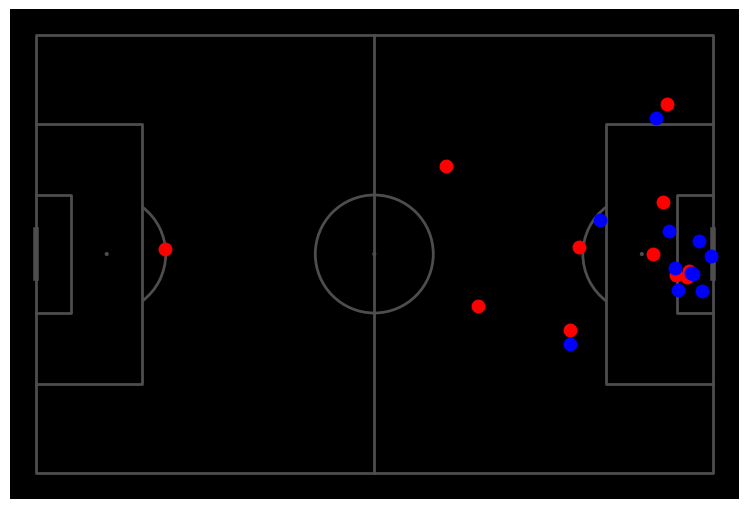

In [7]:
from IPython.display import Video

save_path = 'highest_xg.mp4'
codf_list_sort[0].visualize_frames(save_path)
Video(save_path)

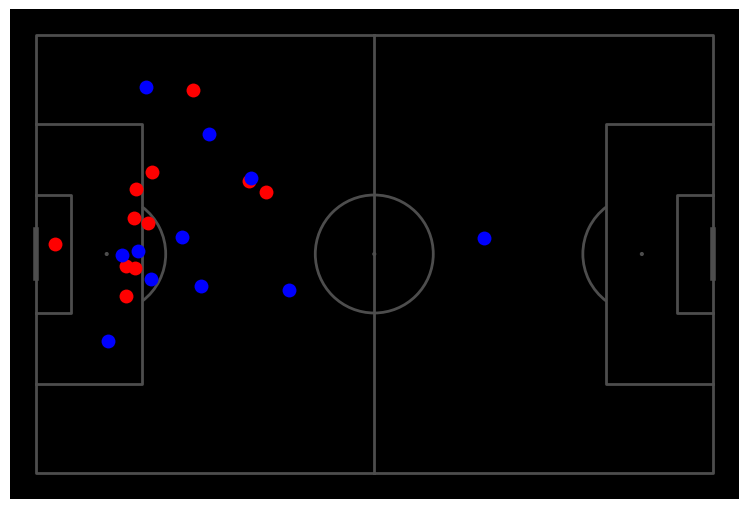

In [8]:
save_path = 'lowest_xg.mp4'
codf_list_sort[-1].visualize_frames(save_path)
Video(save_path)

In [9]:
# sort play quality by Time-Series xG
codf_list_sort_time_series = sorted(codf_list, key=partial(rate_xG_time_series), reverse=True)

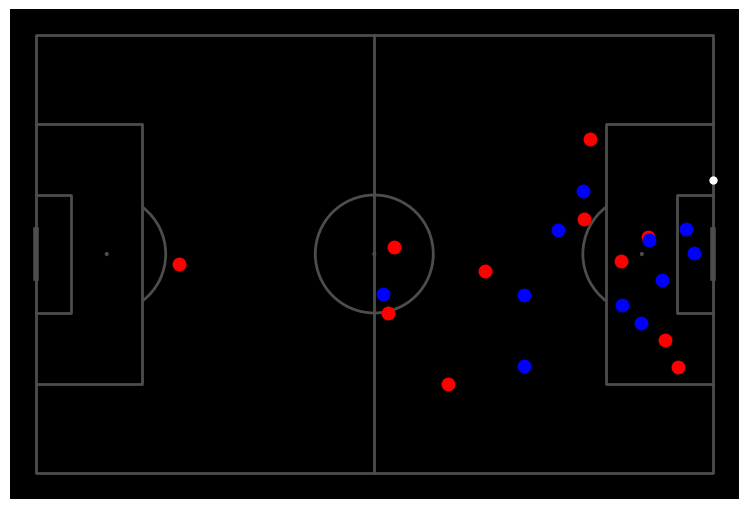

In [10]:
save_path = 'highest_time_series_xg.mp4'
codf_list_sort_time_series[0].visualize_frames(save_path)
Video(save_path)

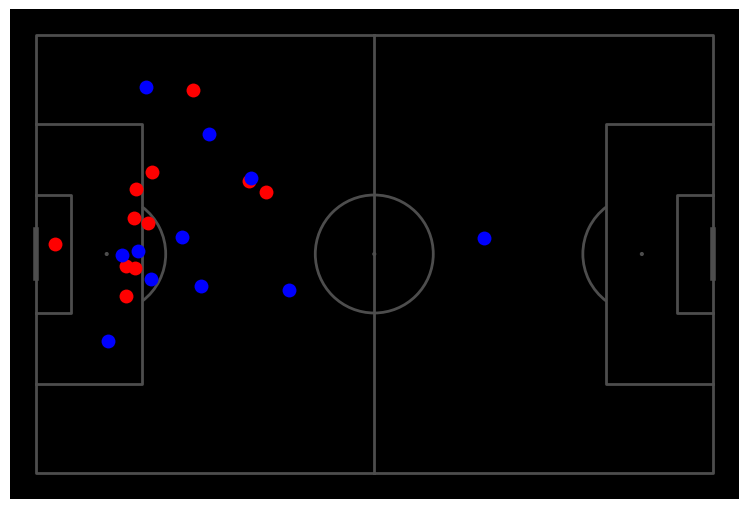

In [11]:
save_path = 'lowest_time_series_xg.mp4'
codf_list_sort[-1].visualize_frames(save_path)
Video(save_path)